In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sys
sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

OUTPUT_FILE = '../reports/report.csv'

TARGET_DICT = {'1': 'binary_target', '2': 'target_more30days', '3': 'target_more90days'}
'''Choose target: 
    1 - binary_target
    2 - target_more30days
    3 - target_more90days
'''

'Choose target: \n    1 - binary_target\n    2 - target_more30days\n    3 - target_more90days\n'

In [2]:
%reload_ext autoreload
%autoreload 2

### Структура

server2022 - основная папка, в которой храним файлы для предобработки данных, генерации признаков и пайплайн обучения модели. 

**prepare_data.py** - файл с фунциями предобработки данных

**train_val.py** - файл с пайплайном модели

**model_features.py** файл c функцими генерации признаков

In [3]:
from server2022.src.train_val import *
from server2022.src.model_features import *
from server2022.data.processed.prepare_data import *

# Постановка задачи 

При решении контеста мы отталкивались в первую очередь от бизнес задачи, а не от абстрактных данных.
В нашем случае бизнеса задача заключается в следующем: зная показатели некоторых компаний за прошлые годы, нужно предсказать будет ли просрочка в этом году у компаний, с которыми мы собираемся работать в этом году.
Так как в нашем распоряжении были данные только за 3 года (2019-2021) и исходя из поставленной бизнес задачи, мы можем строить следующие модели:

    1. Модель, не использующая данные о просрочке платежа компаний за прошлые года. Для каждой компании мы знаем ее финансовые показатели за последние несколько лет и, возможно, знаем факторы, подсчитанные Северсталью.
            учим на 2019; предсказываем на 2020            
            учим на 2019 и 2020; предсказываем на 2021
            
    2. Модель, использует данные компании, которая уже работала с Северсталью прошлый год. В этом случае можно использовать данные о ПДЗ за прошлый год.
        Обучение происходит на данных за 2019-2020, а тестируем на данных 2020-2021.


Других вариантов быть не может в силу поставленной бизнес задачи, так как на момент начала года мы не можем пользоваться данными ПДЗ этого года, даже для других компаний, потому что в реальной ситуации этих данных не будет! Из-за этих обстоятельств некоторые данные становятся невозможно использовать при построении моделей. Например, факторы, которые встречаются только в 2020 году, или “оценку потенциала” контрагента в 2021.

Второй момент в данных, на который хочется обратить внимание, это несбалансированность выборки. Среди компаний, представленных в 2021 году, только у 34% была просрочка, хотя для компании в 2019 и 2020 имели просрочки в 58% и 68% случаев соответственно (60% и 76%, если смотреть на 325 компаний, представленные в 2021). Отсюда встает вопрос, почему вообще такое кардинальное снижение в количестве просрочек. Либо произошло что-то существенное между этими периодами, либо данные начали собираться другим образом, вследствии чего часть просрочек “исчезла”.

         



# Постановка ML задачи 

1) Исходя из сказанного выше **принято решения построить 2 выборки и на них обучить 2 модели**: 

  1. **Уже работали с клиентом** и есть информация, какие просрочки были при работе с ним. Для этого используется функция **create_df_1year_known**, в которой есть колонки о данных по просроченным платежам клиентов

  2. **Клиент новый** и про него нет информации, как он оплачивает. Эту выборку делаем с помощью функции **create_df_0years_known**
  
2) **Правильно построить разделение выборки на тренировочную и тестовую, чтобы не было завышения метрик модели.** 

  1. Нельзя, чтобы данные по клиенту за один год были как в обучающей, так и в тестовой выборке,  
  2. Для 1ой задачи разбить клиенов по id, и чтобы какая-то часть id вообще не попадала в обучающаю выборку, а была только в тесте. 
 
3) **Отобрать признаки, которые дают наибольший прирост качеству моделей**

# описание фичей
Первоначальные запуски модели на исходных данных показали, что **наибольшую роль играют финансовые признаки**. Поэтому в модель добавляли признаки, показывающие финансовое и экономическое развитие компании: 

    1. Разница между показателями за год. Чтобы описать как динамически менялось финансовое состоянии компании,  добавили последовательно разницу между всеми годами, до текущего в выборке.  
    2. Аналогично относительное изменение, т.е. эти величины не исходных единицах измерения, а в относительных, показывающее во сколько раз тот или иной показатель вырос или упал относительно прошлого года. 
    3. Средний прирост каждого финансового показателя для каждого контагента
    4. Логарифм абсолютного значения финансовых признаков 
    5. Нормирование на прирост за год финансового признака


# 1) Модель для клиентов, с которыми уже работали

В этой части работы хотим найти ***оптимальный набор признаков***, который даст наилучшее качество модели. Для этого использовали комбинацию признаков, которые описали выше. ***Введем обозначения для признаков***: 

    1 - use_diff_features
    2 - use_ratio_features
    3 - add_growth
    4 - count_log_fin_vals
    5 - normalize_fin_columns
    
***True означает, что мы использовали признак в дополнении с исходными признаками***, полученными от экспертов Северстали

## Модель для факта, что контрагент допустит просрочку

***Для этой модели наилучшая комбинация признаков - use_diff_features + add_growth.*** 

Ниже представлены часть экспериментов по комбинации признаков для этой модели

In [4]:
TARGET_COL = TARGET_DICT['1']
COMMENT_PREFIX = '0'

In [5]:
model = CatBoostClassifier(iterations=1500,
                               depth=5, 
                               l2_leaf_reg=5, 
                               learning_rate=0.001, # 0.01433
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.01], #0.0006
                               random_seed=RANDOM_STATE,
                              )

## add_growth=True + use_diff_features=True

In [6]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=False, normalize_fin_columns=False, drop_zeros=False)

In [7]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

Target = binary_target
Fitting model <catboost.core.CatBoostClassifier object at 0x000001B305B5BD00> with threshold = 0.06...


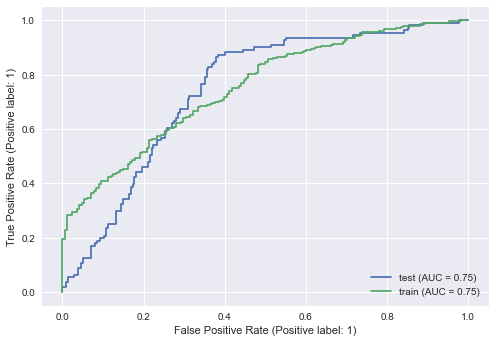

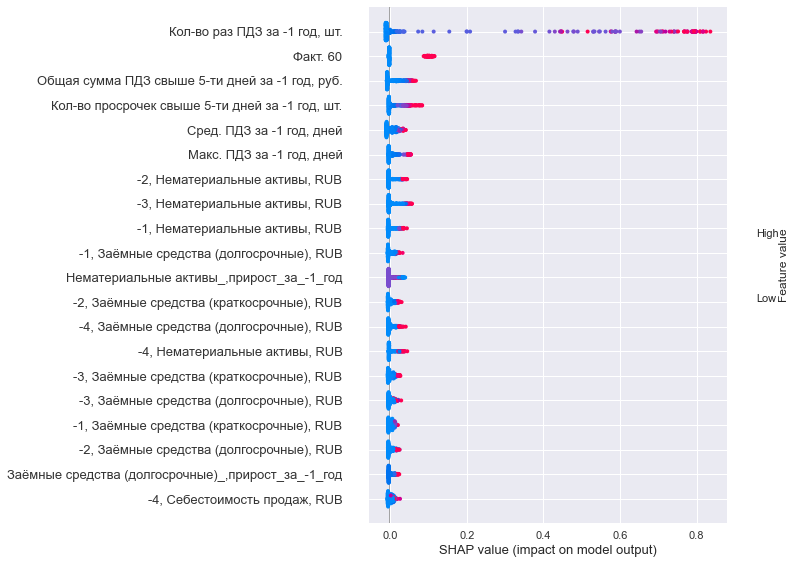


TRAIN: F1 = 0.615, Precision = 0.857, Recall = 0.479, Accuracy = 0.589, ROC_AUC = 0.752
TEST: F1 = 0.662, Precision = 0.53, Recall = 0.883, Accuracy = 0.692, ROC_AUC = 0.746



In [8]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True

In [9]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=False, normalize_fin_columns=True, drop_zeros=False)

In [10]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

Target = binary_target
Fitting model <catboost.core.CatBoostClassifier object at 0x000001B305B5BD00> with threshold = 0.05742...


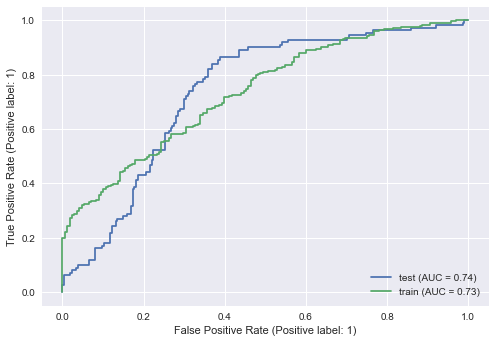

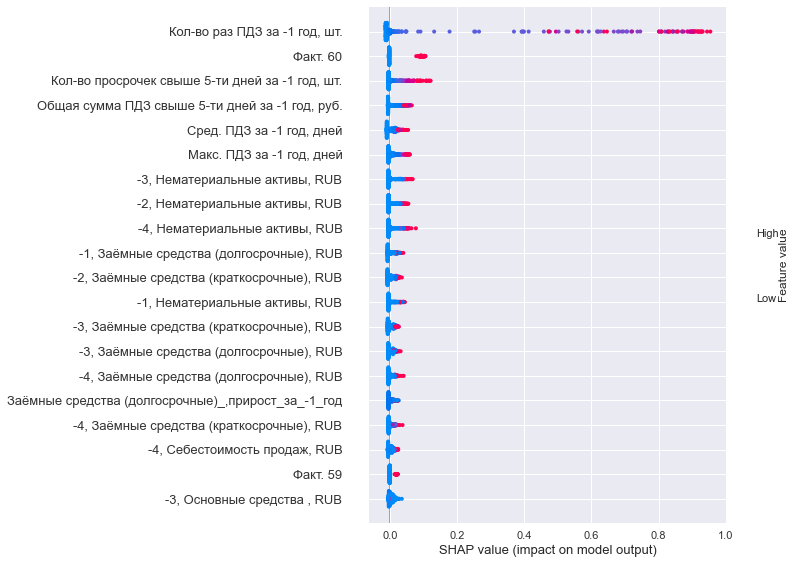


TRAIN: F1 = 0.626, Precision = 0.824, Recall = 0.504, Accuracy = 0.588, ROC_AUC = 0.734
TEST: F1 = 0.651, Precision = 0.522, Recall = 0.865, Accuracy = 0.683, ROC_AUC = 0.738



In [11]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4 + 6')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True + count_log_fin_vals=True

In [12]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=True, normalize_fin_columns=True, drop_zeros=False)

In [13]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

Target = binary_target
Fitting model <catboost.core.CatBoostClassifier object at 0x000001B305B5BD00> with threshold = 0.05727...


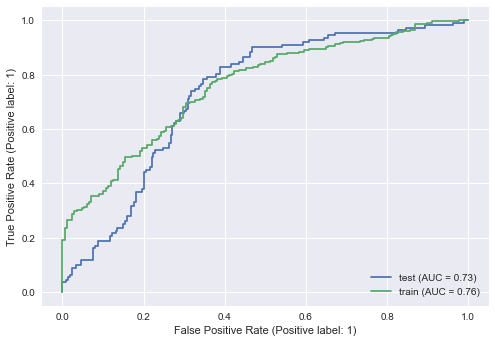

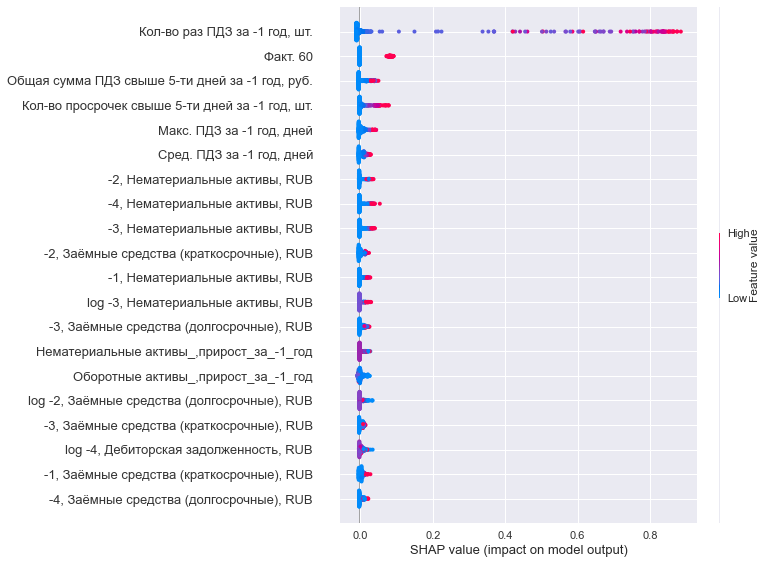


TRAIN: F1 = 0.633, Precision = 0.858, Recall = 0.501, Accuracy = 0.603, ROC_AUC = 0.757
TEST: F1 = 0.634, Precision = 0.5, Recall = 0.865, Accuracy = 0.658, ROC_AUC = 0.731



In [14]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4 + 5 + 6')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True + count_log_fin_vals=True + use_ratio_features=True

In [15]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=True, normalize_fin_columns=True, drop_zeros=False)

In [16]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=True)

In [17]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 3 + 4 + 5 + 6')

Target = binary_target


KeyboardInterrupt: 

## Модель для факта, что контрагент допустит просрочку более 30 дней

***Для этой модели наилучшая комбинация признаков - use_diff_features + add_growth.*** 

Ниже представлены часть экспериментов по комбинации признаков для этой модели

In [ ]:
TARGET_COL = TARGET_DICT['2']
COMMENT_PREFIX = '30'

In [ ]:
model = CatBoostClassifier(iterations=1500,
                               depth=4, 
                               l2_leaf_reg=8.8, 
                               learning_rate=0.0192, # 0.01433
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.1], #0.0006
                               random_seed=RANDOM_STATE,
                              )

## add_growth=True + use_diff_features=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=False, normalize_fin_columns=False, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=False, normalize_fin_columns=True, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4 + 6')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True + count_log_fin_vals=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=True, normalize_fin_columns=True, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4 + 5 + 6')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True + count_log_fin_vals=True + use_ratio_features=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=True, normalize_fin_columns=True, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=True)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 3 + 4 + 5 + 6')

## Модель для факта, что контрагент допустит просрочку больше 90 дней

***Для этой модели наилучшая комбинация признаков - use_diff_features + add_growth + normalize_fin_columns.*** 

Ниже представлены часть экспериментов по комбинации признаков для этой модели

In [ ]:
TARGET_COL = TARGET_DICT['3']
COMMENT_PREFIX = '90'

In [ ]:
model = CatBoostClassifier(iterations=1500,
                               depth=4, 
                               l2_leaf_reg=8.8, 
                               learning_rate=0.0192, # 0.01433
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.1], #0.0006
                               random_seed=RANDOM_STATE,
                              )

## add_growth=True + use_diff_features=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=False, normalize_fin_columns=False, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=False, normalize_fin_columns=True, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4 + 6')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True + count_log_fin_vals=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=True, normalize_fin_columns=True, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=False)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 4 + 5 + 6')

## add_growth=True + use_diff_features=True + normalize_fin_columns=True + count_log_fin_vals=True + use_ratio_features=True

In [ ]:
df = create_df_1year_known(add_growth=True, count_log_fin_vals=True, normalize_fin_columns=True, drop_zeros=False)

In [ ]:
feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df, use_diff_features=True, use_ratio_features=True)

In [ ]:
make_report_with_best_threshold(model, df, to_file=True, target_col=TARGET_COL, num_random_states=5,
                                file_path=OUTPUT_FILE, comment=COMMENT_PREFIX + '2 + 3 + 4 + 5 + 6')

# Факт просрочки длительностью 60-90 дней

Поскольку у нас нет таргета для обучения модели предсказания просрочки платежа на 60-90 дней, мы не сможем построить модель, как это сделали для факта просрочки или факта просрочки выше 30. Но мы можем воспользоваться результатами этих моделей. 

***Идея***: обучим калибровочные модели на вероятность просрочки выше 30 дней и выше 90 дней

Пусть Х - количество дней просрочки, P - вероятность события. Тогда: 

                            P(X > 60 & X < 90) ~ (P(X > 30) - P(X > 90)) * 0.5
                            
Вероятность событий P(X > 30) и P(X < 90) получим с помощью обученных калибровочных моделей для 30 и 90 дней, взяв значение выхода модели, как вероятности.

***Пример***: для контрагента с помощью первой модели получим вероятность просрочки >30 дней - 0.6, а вероятность <90 дней с помощью второй модели - 0.3. Тогда вероятность просрочки от 60 до 90 дней - (0.6 - 0.3) * 0.5 = 0.15.

***Результат***: Если первоначальная модель факта просрочки покажет положительный результат, то при помощи такого решения получим вероятность просрочки именно на 60-90 дн.

In [18]:
df = create_df_1year_known(normalize_fin_columns=False, drop_zeros=False)

feat_gen = Feature_gen(-2, -1)
df = feat_gen.preprocessing_before_fitting(df)

In [19]:
TARGET_COL = TARGET_DICT['2']
model_more_30 = CatBoostClassifier(iterations=1500,
                               depth=5, 
                               l2_leaf_reg=5, 
                               learning_rate=0.001, # 0.01433
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.01], #0.0006
                               random_seed=RANDOM_STATE,
                              )

Target = target_more30days


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MODEL HAS BEEN CALIBRATED!
Fitting model CalibratedClassifierCV(base_estimator=<catboost.core.CatBoostClassifier object at 0x000001B3073812E0>,
                       cv=3) with threshold = 0.51194...


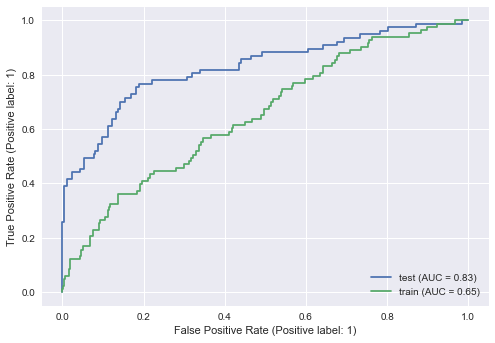


TRAIN: F1 = 0.0, Precision = 0.0, Recall = 0.0, Accuracy = 0.844, ROC_AUC = 0.652
TEST: F1 = 0.075, Precision = 1.0, Recall = 0.039, Accuracy = 0.772, ROC_AUC = 0.828



In [20]:
preds_more_30 = make_report_with_best_threshold(model_more_30, df, to_file=True, target_col=TARGET_COL, num_random_states=1,
                                file_path=OUTPUT_FILE, comment='all features', use_calib=True, calib_coeff=6)

In [21]:
TARGET_COL = TARGET_DICT['3']
model_more_90 = CatBoostClassifier(iterations=1500,
                               depth=5, 
                               l2_leaf_reg=5, 
                               learning_rate=0.001, # 0.01433
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.01], #0.0006
                               random_seed=RANDOM_STATE,
                              )

Target = target_more90days
MODEL HAS BEEN CALIBRATED!
Fitting model CalibratedClassifierCV(base_estimator=<catboost.core.CatBoostClassifier object at 0x000001B30B2950D0>,
                       cv=3) with threshold = 0.24113...


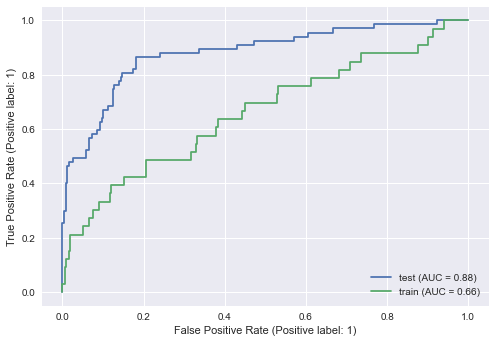


TRAIN: F1 = 0.154, Precision = 0.5, Recall = 0.091, Accuracy = 0.938, ROC_AUC = 0.66
TEST: F1 = 0.304, Precision = 1.0, Recall = 0.179, Accuracy = 0.831, ROC_AUC = 0.88



In [22]:
preds_more_90 = make_report_with_best_threshold(model_more_90, df, to_file=True, target_col=TARGET_COL, num_random_states=1,
                                file_path=OUTPUT_FILE, comment='all features', use_calib=True, calib_coeff = 6)

***Получили, что при наличии факта просрочки, с 12% вероятностью она будет в интервале от 60 до 90 дней***

In [23]:
((preds_more_30 - preds_more_90) * 0.5).mean()

0.126194365145274